In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### utils

##### PatchEmbed

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, kernel_size, stride, padding, in_chans, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride,
            padding=padding
        )
    
    def forward(self, x):
        x = self.proj(x)
        # b,c,h,w -> b,h,w,c
        x = x.permute(0, 2, 3, 1)
        return x

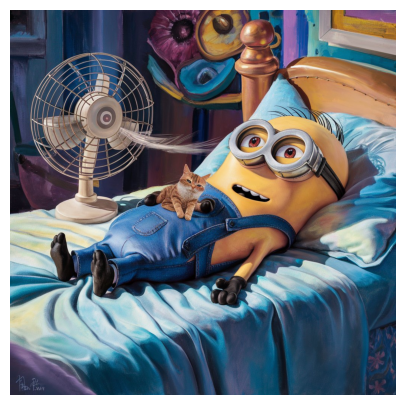

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['figure.figsize'] = [10, 5]

test_image = Image.open('./minion_img.jpeg')
test_image = np.array(test_image)
plt.imshow(test_image)
plt.axis('off')
plt.show()

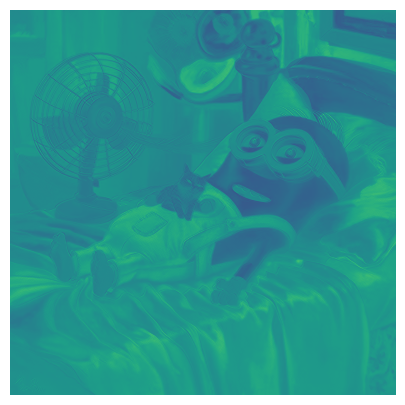

In [5]:
# warmup conv2d (@fastai)
test_image = Image.open('./minion_img.jpeg')
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image)

top_edge_kernel = torch.tensor([
    [[-1, -1, -1],
     [0, 0, 0],
     [1, 1, 1]],
    
    [[-1, 0, 1],
     [-1, 0, 1],
     [-1, 0, 1]],
    
    [[1, 1, 1],
     [0, 0, 0],
     [-1, -1, -1]]
]).float()


def apply_kernel(row, col, kernel, img):
    return (img[row-1:row+2, col-1:col+2] * kernel).sum()

rng = range(1, test_image.shape[0]-2)
after_conv_img = torch.tensor([[apply_kernel(i, j, top_edge_kernel, test_image) for j in rng] for i in rng])
plt.axis('off')
plt.imshow(after_conv_img)
plt.show()


torch.Size([27, 1044484]) torch.Size([1, 1024, 1024, 3]) torch.Size([27]) torch.Size([1022, 1022])


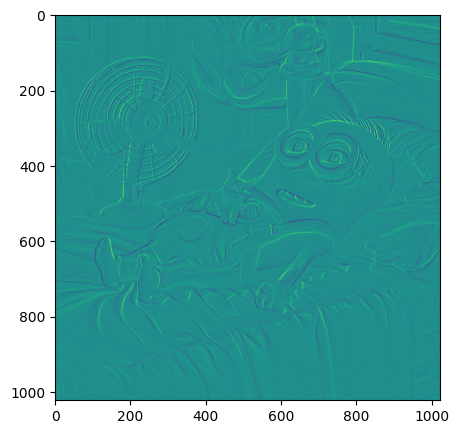

In [6]:
inp = test_image[None, :, :].float()
inp_unf = F.unfold(inp.permute(0, 3, 1, 2), (3, 3))[0]
kernel_weight = top_edge_kernel.view(-1)
output_img = (kernel_weight @ inp_unf).view(1022, 1022)
print(inp_unf.shape, inp.shape, kernel_weight.shape, output_img.shape)
plt.imshow(output_img)
plt.show()

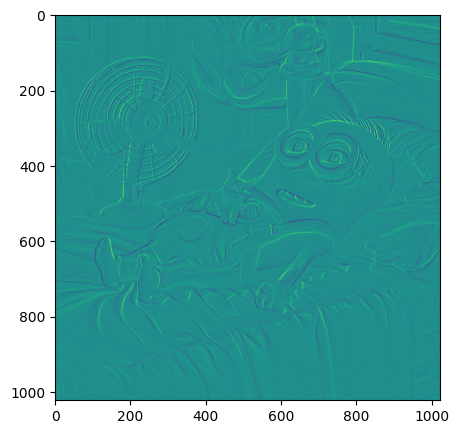

In [7]:
output_img2 = F.conv2d(inp.permute(0, 3, 1, 2), top_edge_kernel[None])
plt.imshow(output_img2[0][0])
plt.show()

In [8]:
inp.shape

torch.Size([1, 1024, 1024, 3])

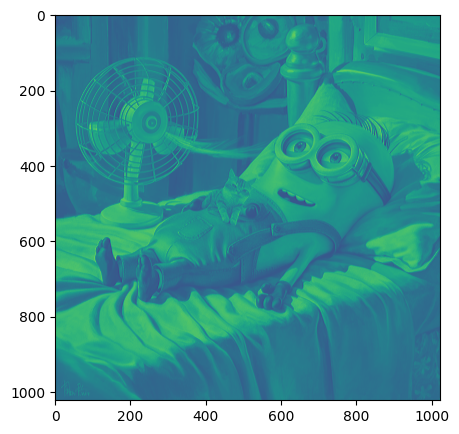

In [9]:
output_img3 = nn.Conv2d(3, 1, kernel_size=3)(inp.permute(0, 3, 1, 2))
plt.imshow(output_img3[0][0].cpu().detach())
plt.show()

In [10]:
PatchEmbed(kernel_size=3, stride=3, padding=0, in_chans=3, embed_dim=64)(inp.permute(0, 3, 1, 2)).shape

torch.Size([1, 341, 341, 64])

##### window_partition

In [11]:
def window_partition(x, window_size):
    B, H, W, C = x.shape

    # this is for padding calculation, such that height and width can be multiplied by window_size
    # H % window_size : gives reminder
    # window_size - H % window_size: subtracting reminder from window_size will how much extra we need to add.
    # final  % window_size make sure to handle already dividable cases.
    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size


    if pad_h > 0 or pad_w > 0:
        # order of padding right to lef so in our case (C, W, H)
        # for each dim you can pad two sides. here we only need to pad one side of hight and width
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    
    Hp, Wp = H + pad_h, W + pad_w

    # make it a view square of hight and width (B, window_size, window_size, window_size, window_size, C)
    x = x.view(B, Hp//window_size, window_size, Wp//window_size, window_size, C)

    # move height window with the corresponding width window this can be done by swapping 2,3 dim to 3,2
    windows = x.permute(0, 1, 3, 2, 4, 5)
    
    # now expand each window to across the batch
    # contiguous required because permute destroys items in contiguous memory but view required items
    # need to be in contiguous memory
    windows = windows.contiguous().view(-1, window_size, window_size, C)
    
    return windows, (Hp, Wp)

In [12]:
x = torch.randn(1, 7, 7, 4).float()

x_t, _ = window_partition(x, window_size=3)
x.shape, x_t.shape


(torch.Size([1, 7, 7, 4]), torch.Size([9, 3, 3, 4]))

##### window_unpartition

In [13]:
def window_unpartition(windows, window_size, pad_hw, hw):
    Hp, Wp = pad_hw
    H, W = hw

    # we need to divide that by total number of windows to recover original batch size
    # total number of windows =  (Hp * Wp // window_size // window_size)
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    
    # move the windows from from the batch dim to individual batch
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    
    # swap the height and width 
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # original dim conversion
    x = x.view(B, Hp, Wp, -1)

    # remove added padding
    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()

    return x

In [14]:
x = torch.randn(1, 7, 7, 4).float()

x_t, pad_hw = window_partition(x, window_size=3)
x.shape, x_t.shape


(torch.Size([1, 7, 7, 4]), torch.Size([9, 3, 3, 4]))

In [15]:
x_r = window_unpartition(x_t, 3, pad_hw, hw=(7, 7))
x_r.shape

torch.Size([1, 7, 7, 4])

##### DropPath

In [63]:
# dropout helper 
class DropPath(nn.Module):
    def __init__(self, drop_prop=0.0, scale_by_keep=True):
        super().__init__()
        self.drop_prop = drop_prop
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        if self.drop_prop == 0.0 or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prop
        
        # calc shape which make all other dim shape 1 except 1 for B,H,W,C -> (B, 1, 1, 1)
        shape = (x.shape[0],) + (1, ) * (x.ndim -1)

        # create empty tensor with 0 values
        # then do bernouli sampling basically. make certain zeros 1 with keep prop
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        if keep_prob > 0.0 and self.scale_by_keep:
            # boost the 1 with prop percentage, this usually done to compensate for zeros.
            random_tensor.div_(keep_prob)
        
        # perform dropout on input
        return x * random_tensor
        
        

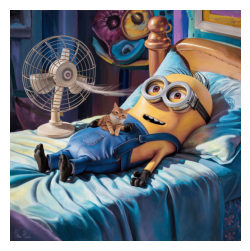

In [64]:
plt.figure(figsize=(3, 3))
plt.imshow(test_image)
plt.axis('off')
plt.show()

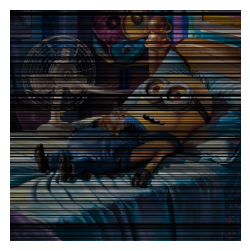

In [74]:
after_dropout = DropPath(drop_prop=0.6, scale_by_keep=False)(test_image.to(torch.float64))
after_dropout = after_dropout.to(torch.uint8).detach().cpu()
plt.figure(figsize=(3, 3))
plt.imshow(after_dropout)
plt.axis('off')
plt.show()



In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, 
                 activation = nn.ReLU):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim]+h, h+[output_dim])
        )

##### hieradet

In [16]:
import torch
import torch.functional as F

In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, trunk, neck, scalp=0):
        super().__init__()
        self.trunk = trunk
        self.neck = neck
        self.scalp = scalp
    
    def forward(self, sample):
        features, pos = self.neck(self.trunk(sample))
        
